In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
train_size = 0.9
lr = 1e-3
eps = 1e-8
batch_size = 512
epochs = 30

Dataset

In [6]:
def mnist(train_part, transform=None):
    dataset = torchvision.datasets.MNIST('.', download=True, transform=transform)
    train_part = int(train_part * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_part, len(dataset) - train_part])
    return train_dataset, test_dataset

In [7]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset, test_dataset = mnist(train_size, transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
dataloaders = (train_dataloader, test_dataloader)

100%|██████████| 9912422/9912422 [00:00<00:00, 147443625.70it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 57193434.29it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 46535621.55it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7559733.64it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Conditional VAE model

In [8]:
from cond_vae import VAEAutoEncoder

In [9]:
model = VAEAutoEncoder()

if torch.cuda.device_count() > 1:
    print(f"using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

using 2 GPUs


DataParallel(
  (module): VAEAutoEncoder(
    (encoder): VAEEncoder(
      (conv1): Conv2d(11, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (z_mean): Linear(in_features=3136, out_features=50, bias=True)
      (z_log): Linear(in_features=3136, out_features=50, bias=True)
      (relu): ReLU()
    )
    (decoder): VAEDecoder(
      (fc1): Linear(in_features=60, out_features=3136, bias=True)
      (reshape): Unflatten(dim=1, unflattened_size=(64, 7, 7))
      (conv1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
      (conv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv3): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (sigmoid): Sigmoid()
    )
  )
)

**LOSS FUNCTION** :- Reconstruction Loss + KL Divergence

In [10]:
def vae_loss(preds, targets, z_mean, z_log, z_val):
    mse = nn.MSELoss()
    reconstruction_loss = mse(preds.view(preds.shape[0], -1), targets.view(targets.shape[0], -1)) * 784.0
    temp = 1.0 + z_log - torch.square(z_mean) - torch.exp(z_log)
    kl_loss = -0.5 * torch.sum(temp, axis=-1)
    return torch.mean(reconstruction_loss + kl_loss)

In [11]:
optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)

In [12]:
def train_vae(dataloaders, model, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]
    epoch_train_losses = []

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch  
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            preds,z_mean, z_log, z_val = model(imgs,labels)
            #print(preds.shape)
            #print(z_val.shape)
            loss = vae_loss(preds, imgs, z_mean, z_log, z_val)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.to(device)
                labels = labels.to(device)

                preds,z_mean, z_log, z_val = model(imgs,labels)
                
                loss = vae_loss(preds, imgs, z_mean, z_log, z_val)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)
        
        epoch_train_losses.append(train_loss)

        tqdm_dct = {'train loss': train_loss, 'test loss': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()
        
    plt.figure(figsize=(5, 3))
    plt.plot(range(1, epochs + 1), epoch_train_losses, label='Train Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

100%|██████████| 30/30 [14:54<00:00, 29.80s/it, train loss=24, test loss=24.2]  


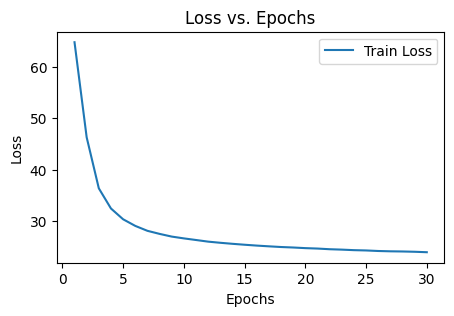

In [13]:
train_vae(dataloaders, model, optimizer, epochs, device)

Visualizing Results

In [14]:
def plotn(n, data):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(data):
        if i == n:
            break
        preprocess = z[0].reshape(1, 28, 28)
        ax[i].imshow(preprocess[0],cmap ='gray')
        ax[i].axis('off')
    plt.show()

torch.Size([1, 1, 28, 28])
torch.Size([1, 50])
torch.Size([1, 1, 28, 28])
torch.Size([1, 50])
torch.Size([1, 1, 28, 28])
torch.Size([1, 50])
torch.Size([1, 1, 28, 28])
torch.Size([1, 50])
torch.Size([1, 1, 28, 28])
torch.Size([1, 50])
torch.Size([1, 1, 28, 28])
torch.Size([1, 50])
torch.Size([1, 1, 28, 28])
torch.Size([1, 50])
torch.Size([1, 1, 28, 28])
torch.Size([1, 50])
torch.Size([1, 1, 28, 28])
torch.Size([1, 50])
torch.Size([1, 1, 28, 28])
torch.Size([1, 50])


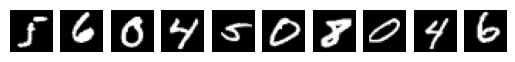

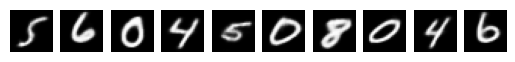

In [15]:
model.eval()
predictions = []
plots = 10
for i, data in enumerate(test_dataset):
    if i == plots:
        break
        
    label_tensor = torch.tensor(data[1]).unsqueeze(0)
    output_imgs = model(data[0].to(device).unsqueeze(0),label_tensor)
    print(output_imgs[0].shape)
    print(output_imgs[3].shape)
    op_img = output_imgs[0].view(1, 28, 28)
    predictions.append(op_img.detach().cpu())
plotn(plots, test_dataset)
plotn(plots, predictions)

# Conditionally generating digits from 0 to 9. Sampling from latent space of dimensions 50 conditioned upon class labels

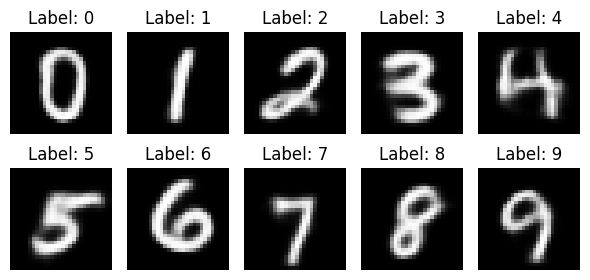

In [16]:
fig, axs = plt.subplots(2, 5, figsize=(6, 3))
for i in range(10):
    rand = torch.randn(1, 50).to(device)
    labels = torch.tensor(i).unsqueeze(0).to(device)
    chek = model.module.decoder(rand, labels)  
    chek = chek.view(1, 28, 28)
    chek = chek.detach().cpu()
    
    row = i // 5
    col = i % 5
    
    axs[row, col].imshow(chek[0], cmap='gray')
    axs[row, col].axis('off')
    axs[row, col].set_title(f'Label: {i}')

plt.tight_layout()  
plt.show()

# Generating 10 samples of each class i.e. digits from 0 to 9

Class Label: 0


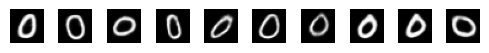

Class Label: 1


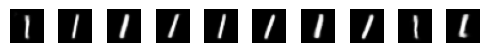

Class Label: 2


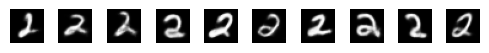

Class Label: 3


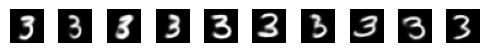

Class Label: 4


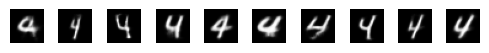

Class Label: 5


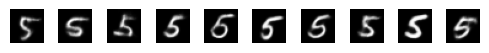

Class Label: 6


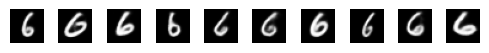

Class Label: 7


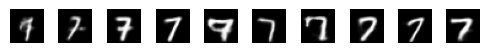

Class Label: 8


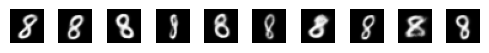

Class Label: 9


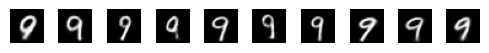

In [17]:
for j in range(10): 
    fig, axs = plt.subplots(1, 10, figsize=(5, 3))
    for i in range(10):
        rand = torch.randn(1, 50).to(device)
        labels = torch.tensor(j).unsqueeze(0).to(device)
        chek = model.module.decoder(rand, labels)  
        chek = chek.view(1, 28, 28)
        chek = chek.detach().cpu()
    
        col = i
    
        axs[col].imshow(chek[0], cmap='gray')
        axs[col].axis('off')
        #axs[col].set_title(f'sample: {i}')

    print(f'Class Label: {j}')
    plt.tight_layout()  
    plt.show()